In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanzi","key":"d5295f70a12723c2149d2185a2c91f52"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d juanzi/trashcat

Dataset URL: https://www.kaggle.com/datasets/juanzi/trashcat
License(s): unknown
100% 1.40G/1.40G [00:08<00:00, 249MB/s]
100% 1.40G/1.40G [00:08<00:00, 184MB/s]


In [ ]:
!unzip trashcat.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_Fix/Metal/Metal_1844.jpg  
  inflating: Dataset_Fix/Metal/Metal_1846.jpg  
  inflating: Dataset_Fix/Metal/Metal_1847.jpg  
  inflating: Dataset_Fix/Metal/Metal_1848.jpg  
  inflating: Dataset_Fix/Metal/Metal_1849.jpg  
  inflating: Dataset_Fix/Metal/Metal_1851.jpg  
  inflating: Dataset_Fix/Metal/Metal_1852.jpg  
  inflating: Dataset_Fix/Metal/Metal_1853.jpg  
  inflating: Dataset_Fix/Metal/Metal_1854.jpg  
  inflating: Dataset_Fix/Metal/Metal_1855.jpg  
  inflating: Dataset_Fix/Metal/Metal_1858.jpg  
  inflating: Dataset_Fix/Metal/Metal_186.jpg  
  inflating: Dataset_Fix/Metal/Metal_1862.jpg  
  inflating: Dataset_Fix/Metal/Metal_1864.jpg  
  inflating: Dataset_Fix/Metal/Metal_1867.jpg  
  inflating: Dataset_Fix/Metal/Metal_1868.jpg  
  inflating: Dataset_Fix/Metal/Metal_187.jpg  
  inflating: Dataset_Fix/Metal/Metal_1870.jpg  
  inflating: Dataset_Fix/Metal/Metal_1873.jpg  
  inflating: Dataset_Fix/Metal/Metal_18

In [ ]:
import os, shutil
import random
import seaborn as sns
from random import sample
import matplotlib.pyplot as plt
from shutil import copyfile
import pathlib
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,  ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras  import Model,layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer,Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten,Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import warnings
from skimage import io
from collections import Counter
warnings.simplefilter(action='ignore',category=FutureWarning)

In [ ]:
import pandas as pd
import seaborn as sns
import random
import cv2
import numpy as np
import os, shutil
from skimage.exposure import adjust_gamma
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte
from skimage import io

In [ ]:
os.makedirs('/content/TrashClas/dataset')

In [ ]:
old_path="/content/Dataset_Fix"

trash_path="/content/TrashClas/dataset"

In [ ]:
for category in os.listdir(old_path):
  category_dir=os.path.join(old_path, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(trash_path, category), dirs_exist_ok=True)

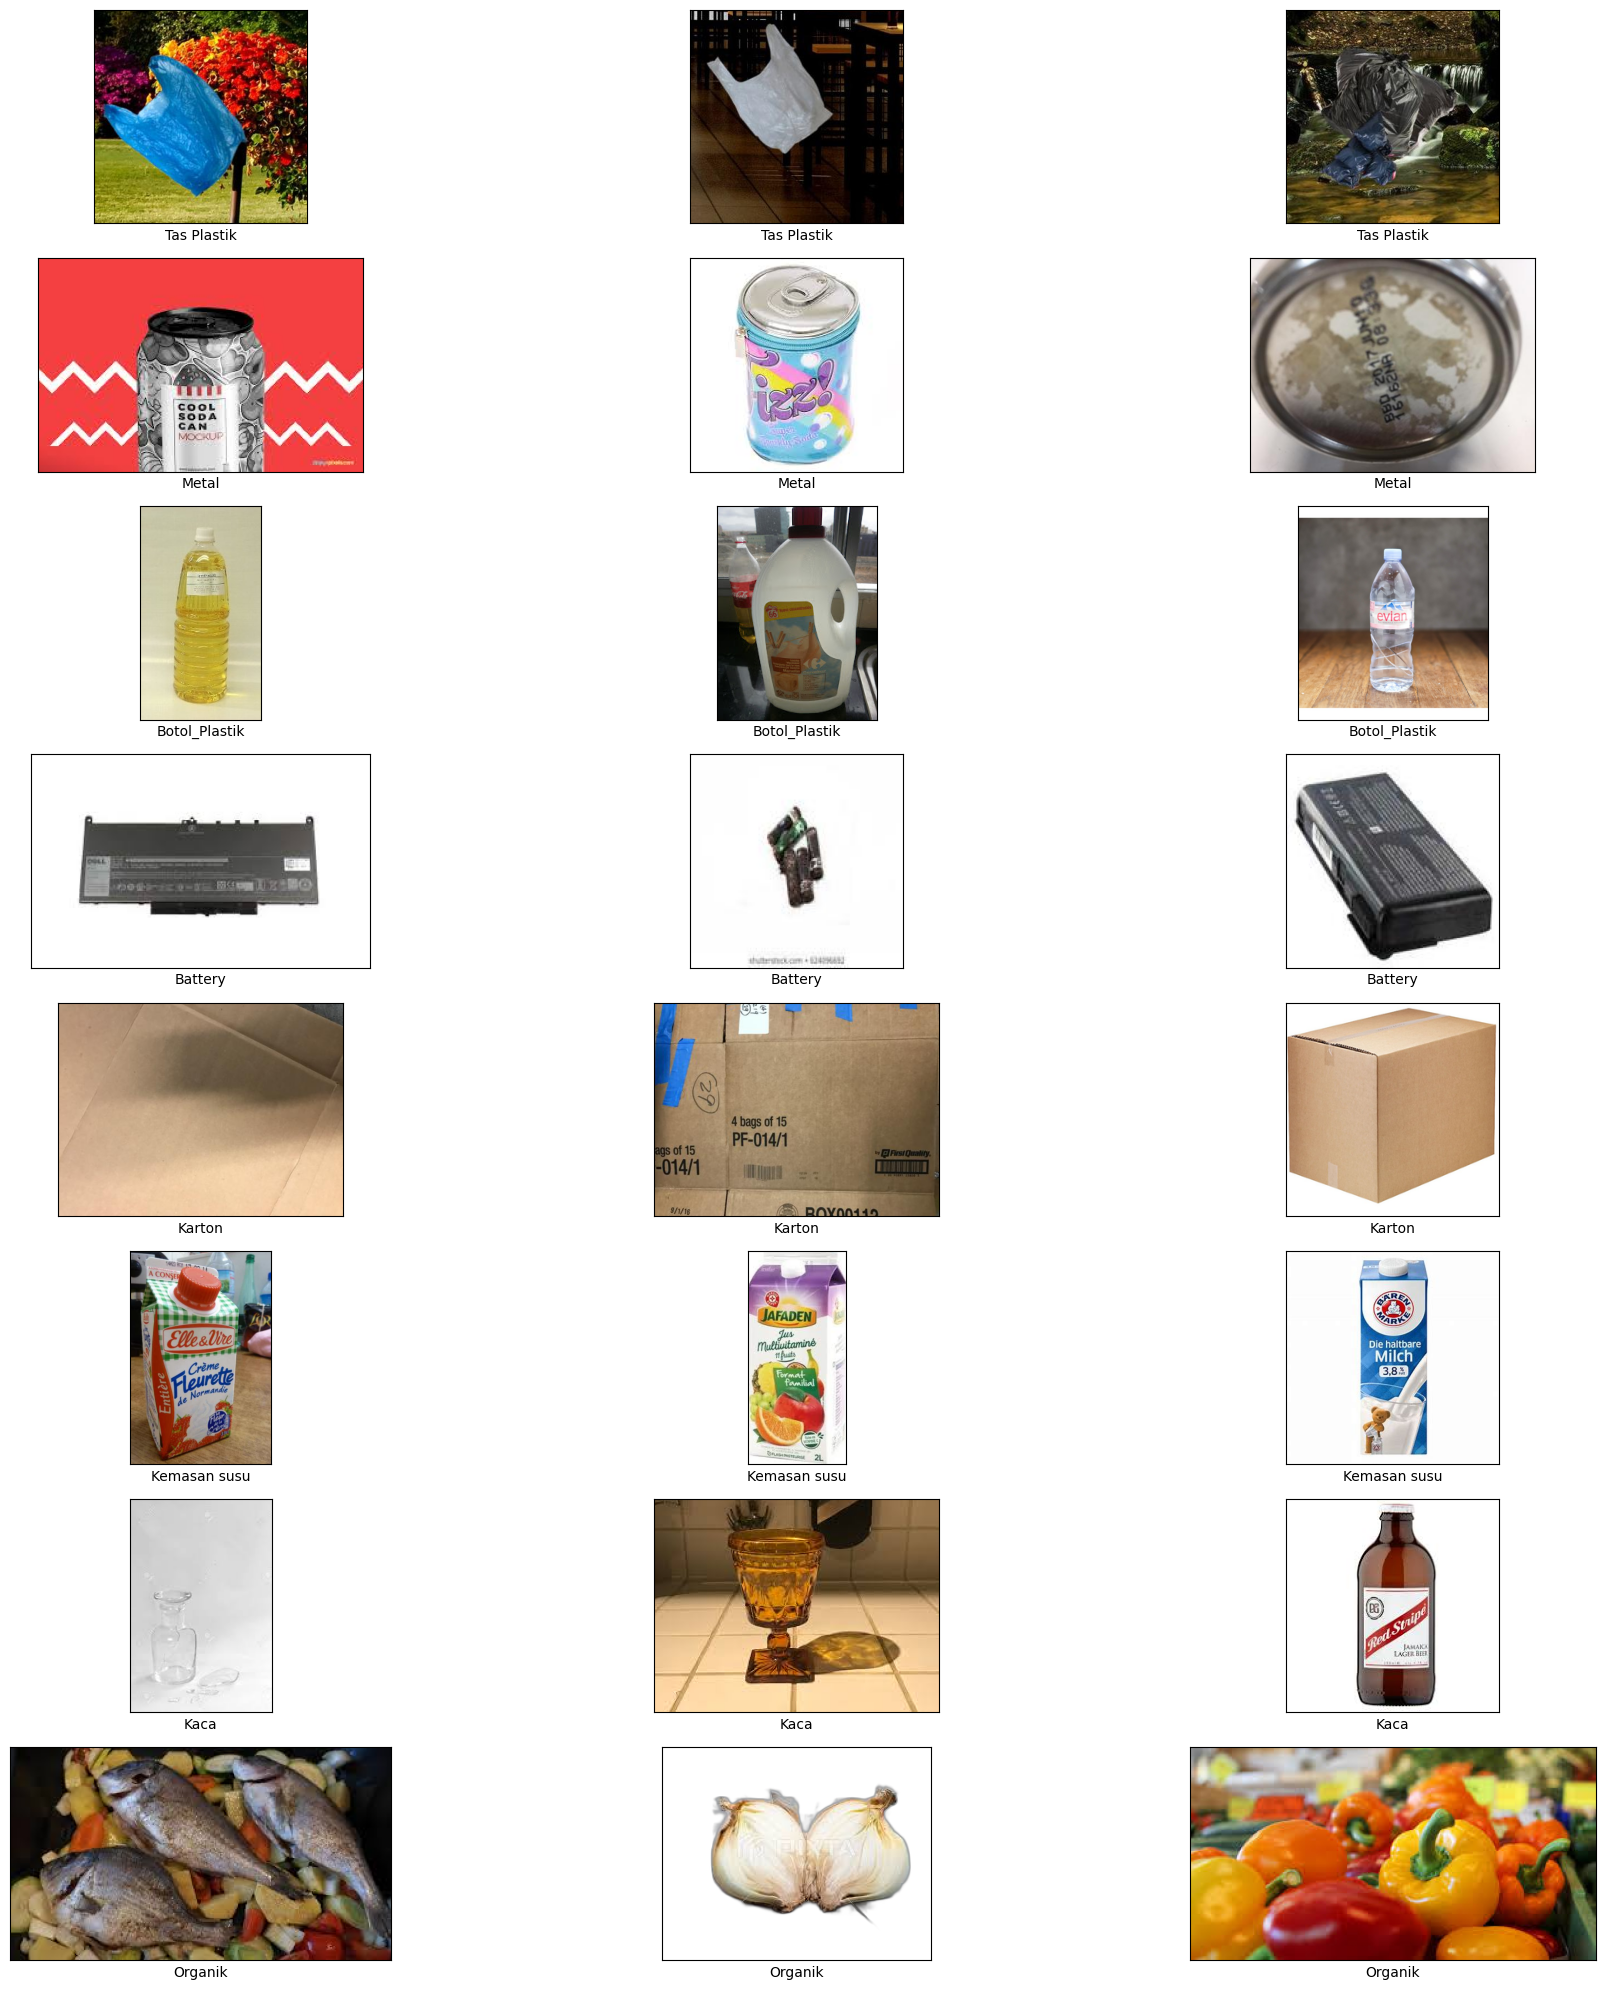

In [ ]:
trash_cat={}
path="/content/TrashClas"
path_sub=os.path.join(path, "dataset")

for i in os.listdir(path_sub):
  trash_cat[i]=os.listdir(os.path.join(path_sub, i))


path_sub="/content/TrashClas/dataset"
fig,axs=plt.subplots(len(trash_cat.keys()), 3, figsize=(20,20))

for i,class_name in enumerate(os.listdir(path_sub)):
  images=np.random.choice(trash_cat[class_name], 3, replace=False)

  for j, image_name in enumerate(images):
    img_path=os.path.join(path_sub, class_name, image_name)
    img=Image.open(img_path)
    axs[i,j].imshow(img)
    axs[i,j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

## Data Preprocessing

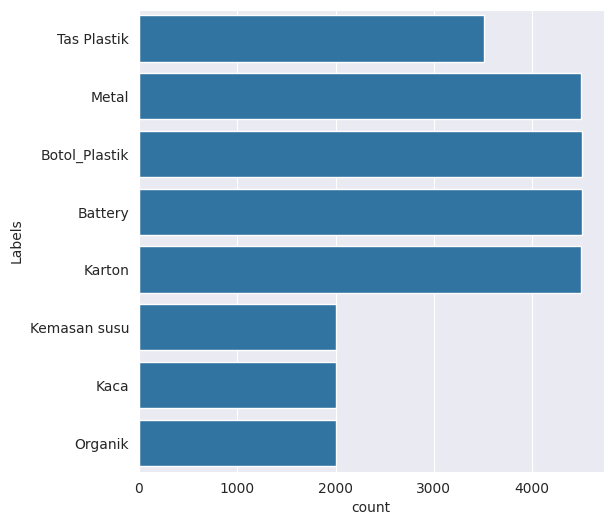

In [ ]:
trash_cat="/content/TrashClas/dataset"

file_name=[]
labels=[]
full_path=[]

for path, subdirs, files in os.walk(trash_cat):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/') [-1])
    file_name.append(name)

distribution_train=pd.DataFrame( {"path":full_path, 'file_name':file_name,"Labels":labels})

Label=distribution_train['Labels']
plt.figure(figsize=(6,6))
sns.set_style('darkgrid')
plt.data=sns.countplot(Label)

In [ ]:
def anticlockwise_rotation(img):
  img=cv2.resize(img,(224,224))
  sudut=random.randint(0,180)
  return rotate(img,sudut)

def clockwise_rotation(img):
  img=cv2.resize(img,(224,224))
  sudut=random.randint(0,180)
  return rotate(img, -sudut)

def flip_up_down(img):
    img=cv2.resize(img, (224,224))
    return np.flipud(img)

def add_brightness(img):
  img=cv2.resize(img,(224,224))
  img=adjust_gamma(img, gamma=0.5, gain=1)
  return img

def blur_imag(img):
  img=cv2.resize(img,(224,224))
  return cv2.GaussianBlur(img,(9,9),0)

def sheared_img(img):
  img=cv2.resize(img,(224,224))
  transform=AffineTransform(shear=0.2)
  shear_image=warp(img, transform,mode="wrap")
  return shear_image

def warp_shift(img):
  img=cv2.resize(img,(224,224))
  transform=AffineTransform(translation=(0,40))
  warp_image=warp(img, transform, mode="wrap")
  return warp_image

In [ ]:
transformations={
    'rotate anticlockwise':anticlockwise_rotation,
    'rotate clockwise':clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image':add_brightness,
    'flip up down':flip_up_down,
    'shear image':sheared_img
}


In [ ]:
categories=['Tas Plastik', 'Metal', 'Botol_Plastik','Battery','Karton','Kemasan susu', 'Kaca','Organik']
base_path="/content/TrashClas/dataset"
target_total_images=4500

for category in categories:
    image_path = os.path.join(base_path, category)
    augmented_path = image_path

    # Ambil semua gambar asli
    images = [os.path.join(image_path, im) for im in os.listdir(image_path) if im.lower().endswith(('.jpg', 'jpeg', 'png'))]
    original_count = len(images)

    # Hitung jumlah gambar yang perlu ditambahkan
    images_to_generate = target_total_images - original_count
    if images_to_generate <= 0:
        print(f"{category} sudah memiliki {original_count} gambar, tidak perlu augmentasi.")
        continue

    print(f"{category}: Menambahkan {images_to_generate} gambar augmentasi untuk mencapai {target_total_images}")

    i = 1
    while i <= images_to_generate:
        image = random.choice(images)
        try:
            original_image = io.imread(image)
            transformed_image = original_image

            # Terapkan sejumlah random transformasi
            transformation_count = random.randint(1, len(transformations))
            for _ in range(transformation_count):
                key = random.choice(list(transformations))
                transformed_image = transformations[key](transformed_image)

            new_image_path = os.path.join(augmented_path, f"augmented_{category}_{i}.jpg")
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(new_image_path, transformed_image)
            i += 1

        except Exception as e:
            print(f'Gagal membaca gambar {image}: {e}, dilewati.')

Tas Plastik: Menambahkan 993 gambar augmentasi untuk mencapai 4500
Metal sudah memiliki 4500 gambar, tidak perlu augmentasi.
Botol_Plastik sudah memiliki 4500 gambar, tidak perlu augmentasi.
Battery sudah memiliki 4500 gambar, tidak perlu augmentasi.
Karton sudah memiliki 4500 gambar, tidak perlu augmentasi.
Kemasan susu sudah memiliki 4500 gambar, tidak perlu augmentasi.
Kaca sudah memiliki 4500 gambar, tidak perlu augmentasi.
Organik: Menambahkan 2496 gambar augmentasi untuk mencapai 4500


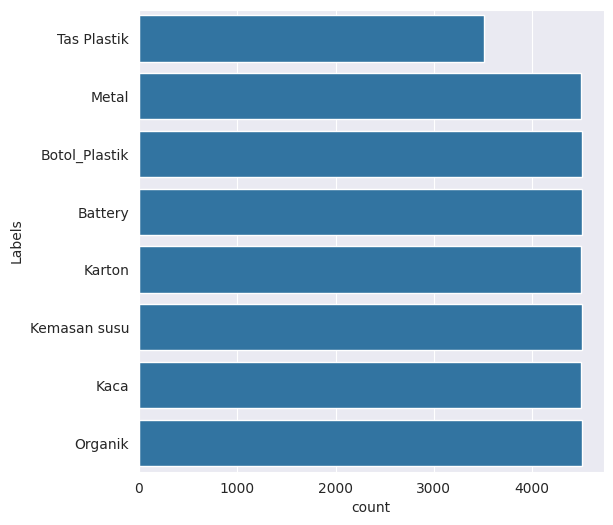

In [ ]:
trash_cat="/content/TrashClas/dataset"

file_name=[]
labels=[]
full_path=[]

for path, subdirs, files in os.walk(trash_cat):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/') [-1])
    file_name.append(name)

distribution_train=pd.DataFrame( {"path":full_path, 'file_name':file_name,"Labels":labels})

Label=distribution_train['Labels']
plt.figure(figsize=(6,6))
sns.set_style('darkgrid')
plt.data=sns.countplot(Label)

In [ ]:
my_path="/content/TrashClas/dataset"

file_name=[]
labels=[]
full_path=[]

for path, subdirs, files in os.walk(my_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

df=pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
Battery,4501
Botol_Plastik,4502
Kaca,4500
Karton,4500
Kemasan susu,4502
Metal,4500
Organik,4501
Tas Plastik,3507


In [ ]:
X=df['path']
y=df['labels']
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=42)


In [ ]:
df_tr=pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_ts=pd.DataFrame({'path':X_test, 'labels':y_test,'set':'test'})


In [ ]:
df_all=pd.concat([df_tr,df_ts],ignore_index=True)
print("============================================\n")
print(df_all.groupby(['set','labels']).size(),'\n')
print("===========================================\n")

print(df_all.sample(5))

datasource_path="/content/Animal_Face/dataset"
dataset_path="/content/Dataset/Final"
os.makedirs(dataset_path, exist_ok=True)


set    labels       
test   Battery           943
       Botol_Plastik     888
       Kaca              913
       Karton            911
       Kemasan susu      842
       Metal             887
       Organik           905
       Tas Plastik       714
train  Battery          3558
       Botol_Plastik    3614
       Kaca             3587
       Karton           3589
       Kemasan susu     3660
       Metal            3613
       Organik          3596
       Tas Plastik      2793
dtype: int64 


                                                    path        labels    set
20702     /content/TrashClas/dataset/Organik/O_13585.jpg       Organik  train
9479   /content/TrashClas/dataset/Metal/augmented_Met...         Metal  train
17596  /content/TrashClas/dataset/Kemasan susu/augmen...  Kemasan susu  train
129    /content/TrashClas/dataset/Battery/Battery_952...       Battery  train
4187   /content/TrashClas/dataset/Kemasan susu/augmen...  Kemasan susu  train


In [ ]:
X=df['path']
y=df['labels']
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=42)


In [ ]:
df_tr=pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_ts=pd.DataFrame({'path':X_test, 'labels':y_test,'set':'test'})


In [ ]:
df_all=pd.concat([df_tr,df_ts],ignore_index=True)
print("============================================\n")
print(df_all.groupby(['set','labels']).size(),'\n')
print("===========================================\n")

print(df_all.sample(5))

datasource_path="/content/Animal_Face/dataset"
dataset_path="/content/Dataset/Final"
os.makedirs(dataset_path, exist_ok=True)


set    labels       
test   Battery           943
       Botol_Plastik     888
       Kaca              913
       Karton            911
       Kemasan susu      842
       Metal             887
       Organik           905
       Tas Plastik       714
train  Battery          3558
       Botol_Plastik    3614
       Kaca             3587
       Karton           3589
       Kemasan susu     3660
       Metal            3613
       Organik          3596
       Tas Plastik      2793
dtype: int64 


                                                    path         labels    set
17766  /content/TrashClas/dataset/Organik/augmented_O...        Organik  train
30505  /content/TrashClas/dataset/Metal/augmented_Met...          Metal   test
15873  /content/TrashClas/dataset/Botol_Plastik/plast...  Botol_Plastik  train
8165   /content/TrashClas/dataset/Botol_Plastik/augme...  Botol_Plastik  train
13231  /content/TrashClas/dataset/Karton/cardboard398...         Karton  train


In [ ]:
for index, row in tq(df_all.iterrows()):
  file_path=row['path']
  if os.path.exists(file_path) ==False:
    file_path=os.path.join(datasource_path, row['labels'], row['image'],split('.')[0])

  if os.path.exists(os.path.join(dataset_path,row['set'], row['labels'])) ==False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels'])) ==True

  destination_file_name=file_path.split('/')[-1]

  file_dest=os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

  if os.path.exists(file_dest) ==False:
    shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
TRAIN_DIR="/content/Dataset/Final/train"
TEST_DIR="/content/Dataset/Final/test"

train_bat=os.path.join(TRAIN_DIR +'/Battery')
train_botp= os.path.join(TRAIN_DIR +'/Botol_Plastik')
train_kaca=os.path.join(TRAIN_DIR +'/Kaca')
train_kar=os.path.join(TRAIN_DIR +'/Karton')
train_kems= os.path.join(TRAIN_DIR +'/Kemasan sus')
train_met=os.path.join(TRAIN_DIR +'/Metal')
train_org=os.path.join(TRAIN_DIR +'/Organik')
train_tasp= os.path.join(TRAIN_DIR +'/Tas Plastik')


test_bat=os.path.join(TEST_DIR +'/Battery')
test_botp= os.path.join(TEST_DIR +'/Botol_Plastik')
test_kaca=os.path.join(TEST_DIR +'/Kaca')
test_kar=os.path.join(TEST_DIR +'/Karton')
test_kems= os.path.join(TEST_DIR +'/Kemasan sus')
test_met=os.path.join(TEST_DIR +'/Metal')
test_org=os.path.join(TEST_DIR +'/Organik')
test_tasp= os.path.join(TEST_DIR +'/Tas Plastik')



In [ ]:
datagen=ImageDataGenerator(rescale=1/225., validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1. /255)
train_generator=datagen.flow_from_directory(TRAIN_DIR,
                                            batch_size=32,
                                            target_size=(150,150),
                                            class_mode='categorical',
                                            subset='training',
                                            shuffle=True
                                            )
validation_generator=datagen.flow_from_directory(TRAIN_DIR,
                                                 batch_size=32,
                                                 target_size=(150,150),
                                                 class_mode='categorical',
                                                 subset='validation',
                                                 shuffle=False)

testing_generator=test_datagen.flow_from_directory(TEST_DIR,
                                                   batch_size=1,
                                                   target_size=(150,150),
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 22407 images belonging to 8 classes.
Found 5597 images belonging to 8 classes.
Found 7003 images belonging to 8 classes.


In [ ]:
model=Sequential()

model.add(Conv2D(32,(3,3), padding='same',activation='relu', input_shape=(150,150,3)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64,(5,5), padding='same',activation='relu'))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (7,7), padding='same', activation='relu'))
model.add(Conv2D(128, (7,7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))


model.add(Conv2D(128, (11,11), padding='same',activation='relu'))
model.add(Conv2D(128, (11,11),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(8,activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 70, 70, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 70, 70, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 35, 35, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 29, 29, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 128)    │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 128)      │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             

 Total params: 5,500,200 (20.98 MB)

 Trainable params: 5,499,496 (20.98 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
class_names = [
    'Battery', 'Botol_Plastik', 'Kaca', 'Karton',
    'Kemasan susu', 'Metal', 'Organik', 'Tas Plastik'
]

# Hitung jumlah gambar untuk tiap kelas
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(TRAIN_DIR, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# Total semua gambar
total_images = sum(class_counts.values())

# Hitung class weights
class_weights = {}
for idx, class_name in enumerate(class_names):
    count = class_counts[class_name]
    class_weights[idx] = (1 / count) * (total_images / len(class_names))



In [ ]:
class CustomCallback(Callback):
  def on_epoch_end(self, epoch,logs=None):
    logs=logs or {}
    val_acc=logs.get('val_accuracy')
    val_loss=logs.get('val_loss')

    if val_acc is not None and val_loss is not None:
      if val_acc >=0.85 and val_loss <=0.55:
        print(f"\nTraining Model Stopped: val_accuracy={val_acc:.2f}, val loss:{val_loss:.2f}")
        self.model.stop_training=True

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy',metrics =['accuracy'])

In [ ]:
history=model.fit(
    train_generator,
    epochs=20,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[CustomCallback()]
)

Epoch 1/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 85s 121ms/step - accuracy: 0.6546 - loss: 1.0526 - val_accuracy: 0.6378 - val_loss: 1.1866
Epoch 2/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 86s 123ms/step - accuracy: 0.6676 - loss: 1.0383 - val_accuracy: 0.6337 - val_loss: 1.0462
Epoch 3/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 86s 123ms/step - accuracy: 0.6876 - loss: 0.9954 - val_accuracy: 0.5374 - val_loss: 1.4076
Epoch 4/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 87s 124ms/step - accuracy: 0.6903 - loss: 0.9711 - val_accuracy: 0.6704 - val_loss: 1.0726
Epoch 5/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 86s 122ms/step - accuracy: 0.7076 - loss: 0.9218 - val_accuracy: 0.6979 - val_loss: 0.9411
Epoch 6/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 86s 123ms/step - accuracy: 0.7113 - loss: 0.9001 - val_accuracy: 0.6607 - val_loss: 1.2432
Epoch 7/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 87s 123ms/step - accuracy: 0.7268 - loss: 0.8642 - val_accuracy: 0.6423 - val_loss: 1.6132
Epoch 8/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 86s 123ms/step - accuracy: 0.7433 - loss: 0